In [1]:
!pip3 install kymatio
!pip3 install scikit-cuda
!pip uninstall --y torchvision
!pip install torch==1.7.0 torchvision==0.8.0
import numpy as np 
import os,csv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import random
from torchvision import transforms
import torch.optim
from PIL import Image
from kymatio.torch import Scattering2D
import pickle
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 102kB 3.8MB/s 
     |████████████████████████████████| 122kB 5.7MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 1.7MB 34.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627360 sha256=74d3c321d9c95c4aa90b7291c745fc5a84446aceb9ba81d59588e365b90b61cf
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.3-py2.py3-none-any.whl size=60512 sha256=0f37d31bd86b82c5f26d2c27ab45a02c706bea12227e9ad854b3b44d9104445b
  Stored in directory: /root/.cache/pip/wheels/d0/c9/8a/fae4cdf6d718d3d63a5a24ed2b49cfd4668257e4a05ff50ced
Successfully built pytools
Uninstallin

In [ ]:
# !unzip -q /content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET.zip -d /content/drive/MyDrive/cv/DUNET-HC-18_Data/

In [2]:
import csv
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# 4/1AY0e-g4UbHq_CkCkQLG7ug0yUnXepWmT7pS_gsiVPgrnh2-PU7RKqA7JzTk

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#UNET - smp (without validation)

In [11]:
NUM_EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [4]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

In [5]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [6]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [7]:
traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
i=0
trainname=[]
# start=0
# with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        # if (start>20):
        #   break
        # start+=1
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [8]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [24]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [13]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [14]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [15]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)

criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [16]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [ ]:
model.train()

# iou_score = []
# dice_loss = []
best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score.append(np.mean(iou))
    dice_loss.append(np.mean(loss_arr))
    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score':iou_score, 'dice_loss': dice_loss}, fid)

    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
    

    if iou_score[-1]>best_iou_score:
        best_iou_score = iou_score[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

Mini - Batch  0 Loss 0.021214544773101807
Mini - Batch  1 Loss 0.01907259225845337
Mini - Batch  2 Loss 0.02101236581802368
Mini - Batch  3 Loss 0.02057284116744995
Mini - Batch  4 Loss 0.020450592041015625
Mini - Batch  5 Loss 0.030449986457824707
Mini - Batch  6 Loss 0.03133261203765869
Mini - Batch  7 Loss 0.01765298843383789
Mini - Batch  8 Loss 0.01751500368118286
Mini - Batch  9 Loss 0.018945515155792236
Mini - Batch  10 Loss 0.02065378427505493
Mini - Batch  11 Loss 0.01864534616470337
Mini - Batch  12 Loss 0.01918935775756836
Mini - Batch  13 Loss 0.10889476537704468
Mini - Batch  14 Loss 0.019932568073272705
Mini - Batch  15 Loss 0.019515395164489746
Mini - Batch  16 Loss 0.019215166568756104
Mini - Batch  17 Loss 0.020208537578582764
Mini - Batch  18 Loss 0.01915454864501953
Mini - Batch  19 Loss 0.033556580543518066
Mini - Batch  20 Loss 0.022911906242370605
Mini - Batch  21 Loss 0.02058929204940796
Mini - Batch  22 Loss 0.025613903999328613
Mini - Batch  23 Loss 0.025409042

In [ ]:
print(best_iou_score)

75.69110210226259


In [115]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score = data['iou_score']
    dice_loss = data['dice_loss']
    print(np.min(dice_loss))

0.012475252151489258


In [ ]:
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

[0.06633484363555908, 0.04668140411376953, 0.016146481037139893, 0.02465158700942993, 0.019250571727752686, 0.020774662494659424, 0.023060321807861328, 0.02046024799346924, 0.029141128063201904, 0.016587555408477783, 0.02340000867843628, 0.11828988790512085, 0.03142637014389038, 0.022098541259765625, 0.03780508041381836, 0.012475252151489258, 0.030152320861816406, 0.021212637424468994, 0.019203007221221924, 0.022825181484222412, 0.015554368495941162, 0.02856731414794922, 0.023510098457336426, 0.01956188678741455, 0.05831611156463623, 0.0261419415473938, 0.043502211570739746, 0.017747163772583008, 0.01913630962371826, 0.020182669162750244, 0.022662341594696045, 0.0169450044631958, 0.016204416751861572, 0.018232643604278564, 0.01950240135192871, 0.020068764686584473, 0.015690863132476807, 0.014597892761230469, 0.015389025211334229, 0.026018917560577393, 0.01997053623199463, 0.015130758285522461, 0.020107686519622803, 0.021684348583221436, 0.015403389930725098, 0.013428211212158203, 0.018

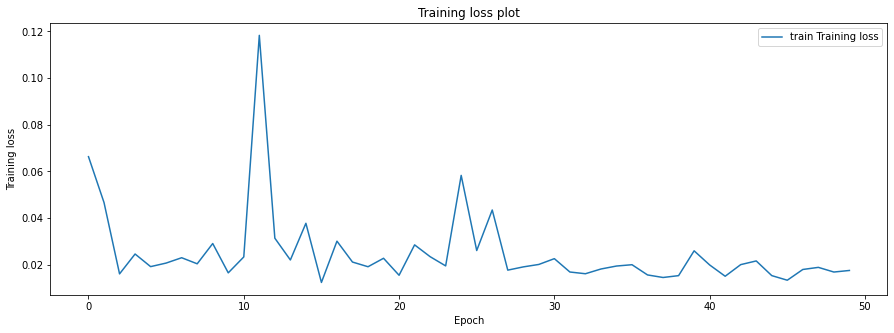

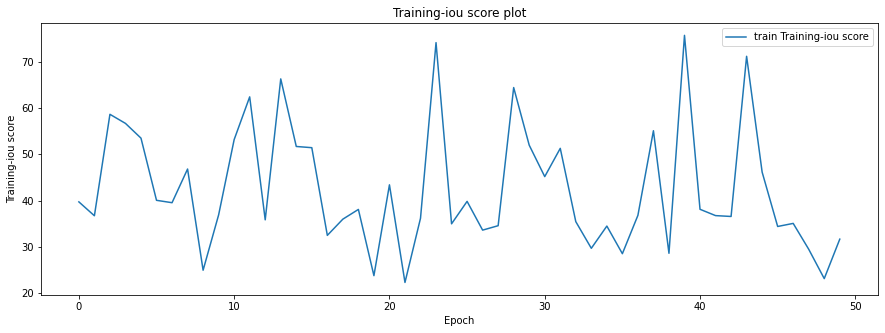

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [19]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model'))

<All keys matched successfully>

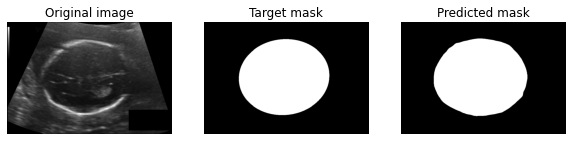

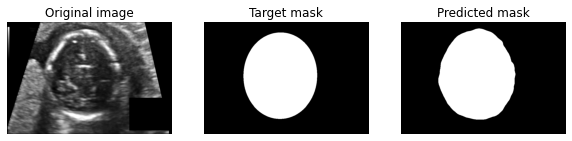

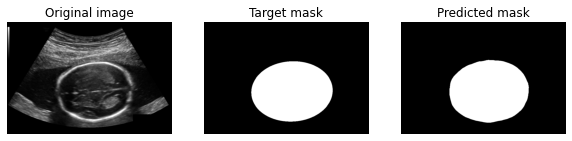

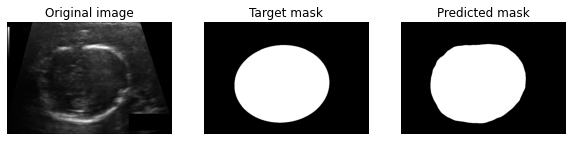

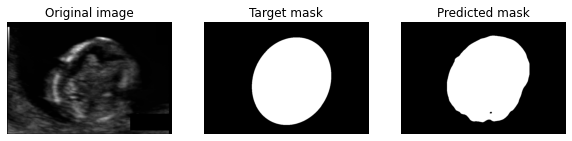

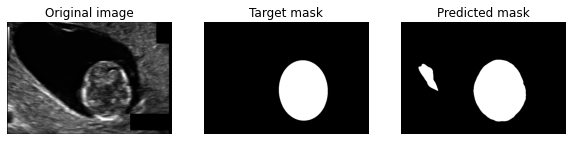

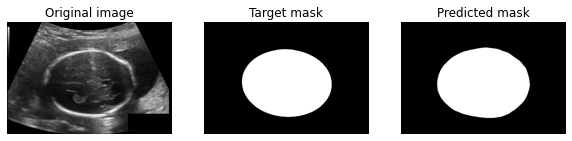

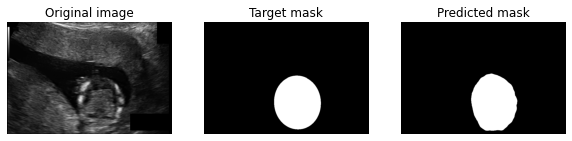

Finished Evaluation


In [21]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))


        # loss = criterion(out, masks)
        # print("Mini - Batch ",k,"Loss", loss.item())
        # print("output:",outputs.shape)

        # Detach
        # print(images[0].shape)
        
        # Plot and see
        

        # i = 0
        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()

        # i = 1
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # # output = transforms.ToPILImage()(outputs[i])
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')

        # i = 2
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # # output = transforms.ToPILImage()(outputs[i])
        # # output=np.array(output)
        # # output[output>75]=255
        # # output[output<=75]=0
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)co
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')
        # # print(np.array(output))
        # # print(output.max())
        # # print(output.mean())
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [22]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

print('Finished Evaluation')
print('iou:',np.mean(iou))

Finished Evaluation
iou: 93.7684475583124


In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp(dont\ touch)/best_iou.pkl', 'wb') as fid:
    pickle.dump(np.mean(iou))

#UNET - smp

In [25]:
NUM_EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [26]:
# def getImageName(filename):
#     imageName = filename[:-4] + '_Annotation.png'
#     return imageName

In [27]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [28]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [29]:
# traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
# i=0
# trainname=[]
# # start=0
# # with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
# with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
#     r=csv.reader(s)
#     for com in r:
#         # if (start>20):
#         #   break
#         # start+=1
#         if i==0:
#             i+=1
#         else:
#             i+=1
#             trainname.append(com[0])
# files=trainname

In [30]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [31]:
# train, val = train_test_split(files, test_size = 0.2)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'wb') as fid:
#     pickle.dump(train, fid)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'wb') as fid:
#     pickle.dump(val, fid)

with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'rb') as fid:
    train = pickle.load(fid)
with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'rb') as fid:
    val = pickle.load(fid)
    
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,train,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

Val_Dataset = HeadDataset(image_folder,mask_folder,val,transform)
valLoader = DataLoader(Val_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [32]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [33]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [34]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)

criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [35]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [40]:
iou_score_train = []
dice_loss_train = []
iou_score_val= []
dice_loss_val = []

best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    ##training
    model.train()
    for i, data in enumerate(trainLoader, 0):

        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Training: Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score_train.append(np.mean(iou))
    dice_loss_train.append(np.mean(loss_arr))

    ##evaluation
    model.eval()
    with torch.no_grad():
        iou = []
        loss_arr = []
        for k, data in enumerate(valLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images = data['image'].to(device)
            masks = data['mask'].to(device)
            # scatters = data['scatter']

            outputs = model(images)
            loss = criterion(outputs, masks)
            print("Validation: Mini - Batch ",k,"Loss", loss.item())

            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())
   
    iou_score_val.append(np.mean(iou))
    dice_loss_val.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score_train':iou_score_train, 'dice_loss_train': dice_loss_train, 'iou_score_val':iou_score_val, 'dice_loss_val':dice_loss_val}, fid)

    if epoch % 1 == 0:
        print("Epoch [{}]: Train - iou: {}, loss: {}; Val - iou: {}, loss: {}".format(epoch, iou_score_train[-1], dice_loss_train[-1], iou_score_val[-1], dice_loss_val[-1]))
        running_loss = 0.0
    

    if iou_score_val[-1]>best_iou_score:
        best_iou_score = iou_score_val[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

Training: Mini - Batch  0 Loss 0.026248931884765625
Training: Mini - Batch  1 Loss 0.054260194301605225
Training: Mini - Batch  2 Loss 0.07227569818496704
Training: Mini - Batch  3 Loss 0.033663928508758545
Training: Mini - Batch  4 Loss 0.026233017444610596
Training: Mini - Batch  5 Loss 0.061150312423706055
Training: Mini - Batch  6 Loss 0.021194279193878174
Training: Mini - Batch  7 Loss 0.02770596742630005
Training: Mini - Batch  8 Loss 0.10721147060394287
Training: Mini - Batch  9 Loss 0.020236670970916748
Training: Mini - Batch  10 Loss 0.09155690670013428
Training: Mini - Batch  11 Loss 0.060439229011535645
Training: Mini - Batch  12 Loss 0.09414732456207275
Training: Mini - Batch  13 Loss 0.033243417739868164
Training: Mini - Batch  14 Loss 0.032467663288116455
Training: Mini - Batch  15 Loss 0.04449915885925293
Training: Mini - Batch  16 Loss 0.020486772060394287
Training: Mini - Batch  17 Loss 0.028703689575195312
Training: Mini - Batch  18 Loss 0.0656050443649292
Training: M

KeyboardInterrupt: ignored

In [41]:
print(best_iou_score)

93.2574767776186


In [42]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train = data['iou_score_train']
    dice_loss_train = data['dice_loss_train']
    iou_score_val = data['iou_score_val']
    dice_loss_val = data['dice_loss_val']
    print(dice_loss_val[np.argmax(iou_score_val)])
    print(np.max(iou_score_val))

0.02566990613937378
93.2574767776186


In [43]:
epoch_train_losses = dice_loss_train
epoch_train_iou = iou_score_train
epoch_val_losses = dice_loss_val
epoch_val_iou = iou_score_val
print(epoch_train_losses)
print(epoch_train_iou)
print(epoch_val_losses)
print(epoch_val_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

[0.028444945812225342, 0.02141052484512329, 0.1364048719406128, 0.03808015584945679, 0.024905145168304443, 0.018673598766326904, 0.02346813678741455, 0.023013412952423096, 0.02680361270904541, 0.023278892040252686]
[88.89570873791418, 94.23199897485166, 78.77414910989337, 90.49943517813645, 93.09209101466197, 94.62085967679121, 92.6956529177759, 94.23009536592926, 92.87378958398976, 94.26282324075753]
[0.03444253206253052, 0.044856810569763185, 0.04481154441833496, 0.038994777202606204, 0.09603448390960694, 0.03084975719451904, 0.0425615406036377, 0.02958212614059448, 0.02566990613937378, 0.02997505187988281]
[90.15022317378984, 88.67282829799323, 89.67252892625997, 90.10136437431865, 84.69569567499688, 91.41623712142714, 89.22507077418028, 91.56658300933114, 93.2574767776186, 92.35615729672978]


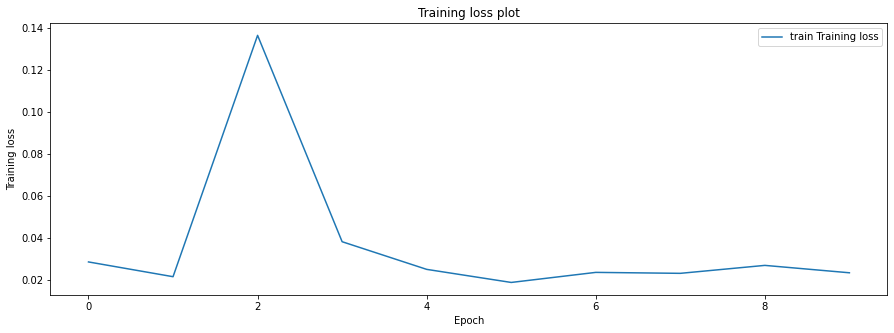

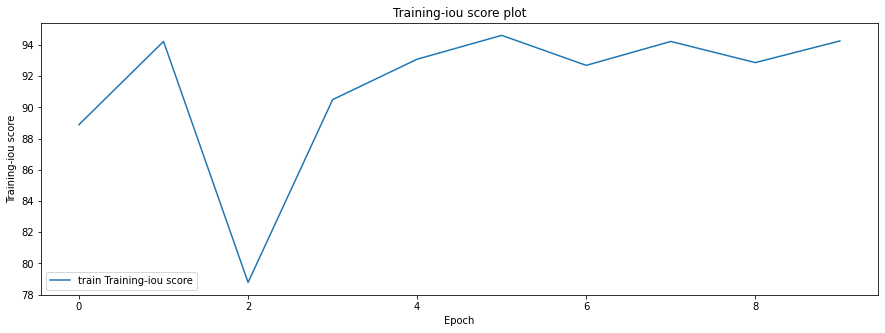

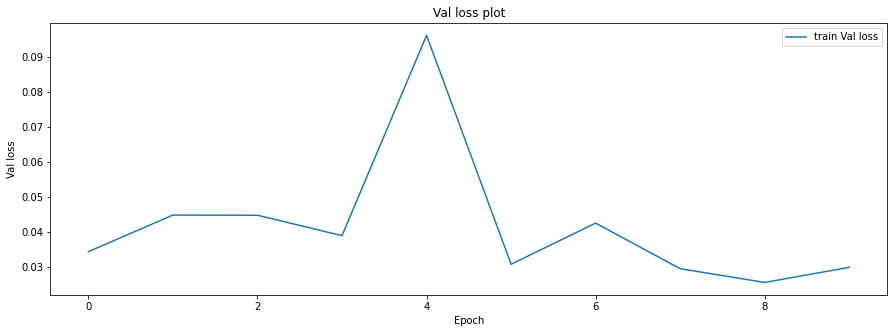

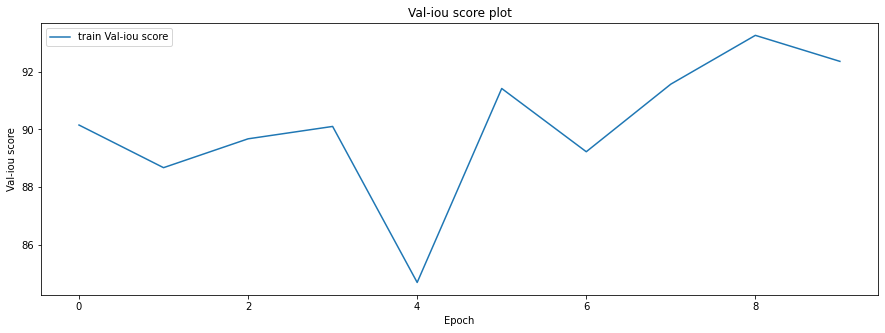

In [44]:
#25epochs-test_train split
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")
plot(epoch_val_losses, "Val loss")
plot(epoch_val_iou, "Val-iou score")

In [45]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model'))

<All keys matched successfully>

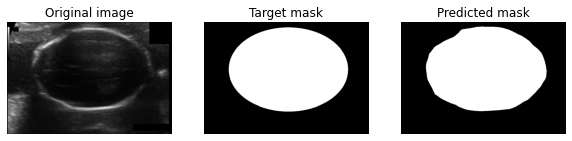

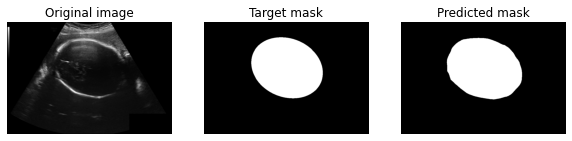

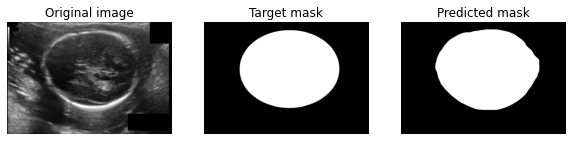

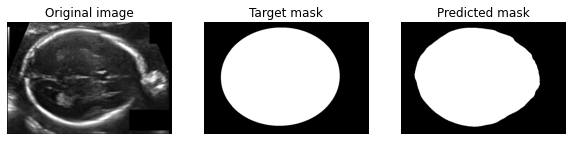

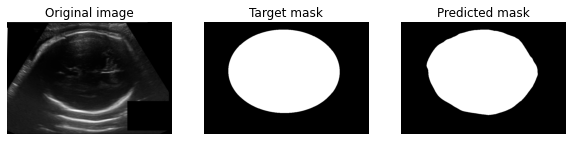

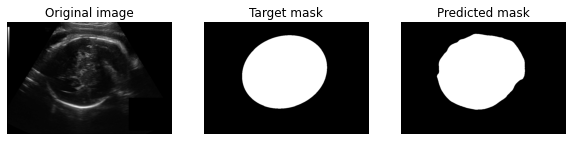

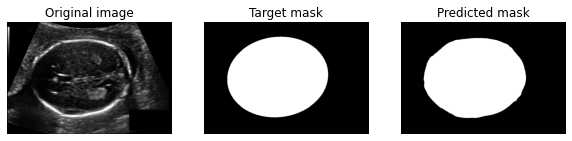

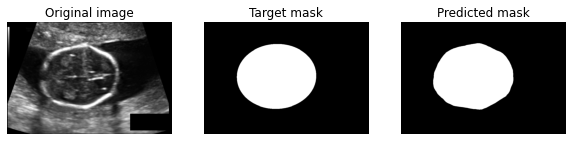

Finished Evaluation


In [46]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(valLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))


        # loss = criterion(out, masks)
        # print("Mini - Batch ",k,"Loss", loss.item())
        # print("output:",outputs.shape)

        # Detach
        # print(images[0].shape)
        
        # Plot and see
        

        # i = 0
        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()

        # i = 1
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # # output = transforms.ToPILImage()(outputs[i])
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')

        # i = 2
        # image = transforms.ToPILImage()(images[i])
        # plt.subplot(3,3,3*i+1)
        # plt.imshow(image, 'gray')
        # mask = transforms.ToPILImage()(masks[i])
        # plt.subplot(3,3,3*i+2)
        # plt.imshow(mask,cmap='gray')
        # # output = transforms.ToPILImage()(outputs[i])
        # # output=np.array(output)
        # # output[output>75]=255
        # # output[output<=75]=0
        # output = torch.sigmoid(outputs[i])
        # output = (output.data > 0.57).long()
        # print(output)co
        # # output = transforms.ToPILImage()(output)
        # output = torch.squeeze(output, 0)
        # plt.subplot(3,3,3*i+3)
        # plt.imshow(output.cpu(),cmap='gray')
        # # print(np.array(output))
        # # print(output.max())
        # # print(output.mean())
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

print('Finished Evaluation')
print('iou:',np.mean(iou))

Finished Evaluation
iou: 93.7684475583124


#UNET - prajwal

In [48]:
NUM_EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 1e-3

In [100]:
# def getImageName(filename):
#     imageName = filename[:-4] + '_Annotation.png'
#     return imageName

In [49]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample

In [50]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [51]:
# traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
# i=0
# trainname=[]
# start=0
# # with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
# with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
#     r=csv.reader(s)
#     for com in r:
#         # if (start>20):
#         #   break
#         # start+=1
#         if i==0:
#             i+=1
#         else:
#             i+=1
#             trainname.append(com[0])
# files=trainname

In [52]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [53]:
# # train, val = train_test_split(files, test_size = 0.2)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'wb') as fid:
#     pickle.dump(train, fid)
# with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'wb') as fid:
#     pickle.dump(val, fid)

with open('/content/drive/MyDrive/cv/anushree/HC-18/train.pkl', 'rb') as fid:
    train = pickle.load(fid)
with open('/content/drive/MyDrive/cv/anushree/HC-18/val.pkl', 'rb') as fid:
    val = pickle.load(fid)
    
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,train,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

Val_Dataset = HeadDataset(image_folder,mask_folder,val,transform)
valLoader = DataLoader(Val_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [54]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [55]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
       
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),   
            nn.MaxPool2d(2, stride=2), nn.ReLU(True)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),   nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),  
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),   
            nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),   
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.conv_merge_1= nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_2= nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_3= nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_4= nn.Sequential(
            nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_5=nn.Sequential(
            nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2), 
            nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), 
            nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), 
            nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), 
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.Conv2d(32, 1, 3, padding=1),   nn.ReLU(True),
        )

    def forward(self, x):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x4 = self.encoder_4(x3)
        x5 = self.encoder_5(x4)
        # b = self.scatter(y)
        # c = torch.cat([x5,b],dim=1)
        # print("Model", x5.shape, b.shape, c.shape)
        d = self.conv_merge_1(x5)
        y1 = self.decoder_1(d)
        f = torch.cat([x4,y1],dim=1)
        g = self.conv_merge_2(f)
        y2 = self.decoder_2(g)
        h = torch.cat([x3,y2],dim=1)
        i = self.conv_merge_3(h)
        y3 = self.decoder_3(i)
        j = torch.cat([x2,y3],dim=1)
        k = self.conv_merge_4(j)
        y4 = self.decoder_4(k)
        l = torch.cat([x1,y4],dim=1)
        m = self.conv_merge_5(l)
        n = self.decoder_5(m)
        return n

model = Unet().to(device=device)
# summary(Unet_model, (1, 544, 800))

In [56]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [57]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [58]:
iou_score_train = []
dice_loss_train = []
iou_score_val= []
dice_loss_val = []

best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    ##training
    model.train()
    for i, data in enumerate(trainLoader, 0):

        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Training: Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score_train.append(np.mean(iou))
    dice_loss_train.append(np.mean(loss_arr))

    ##evaluation
    model.eval()
    with torch.no_grad():
        iou = []
        loss_arr = []
        for k, data in enumerate(valLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images = data['image'].to(device)
            masks = data['mask'].to(device)
            # scatters = data['scatter']

            outputs = model(images)
            loss = criterion(outputs, masks)
            print("Validation: Mini - Batch ",k,"Loss", loss.item())

            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())
   
    iou_score_val.append(np.mean(iou))
    dice_loss_val.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score_train':iou_score_train, 'dice_loss_train': dice_loss_train, 'iou_score_val':iou_score_val, 'dice_loss_val':dice_loss_val}, fid)

    if epoch % 1 == 0:
        print("Epoch [{}]: Train - iou: {}, loss: {}; Val - iou: {}, loss: {}".format(epoch, iou_score_train[-1], dice_loss_train[-1], iou_score_val[-1], dice_loss_val[-1]))
        running_loss = 0.0
    

    if iou_score_val[-1]>best_iou_score:
        best_iou_score = iou_score_val[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet-smp/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

Training: Mini - Batch  0 Loss 0.9998943209648132


RuntimeError: ignored

In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train = data['iou_score_train']
    dice_loss_train = data['dice_loss_train']
    iou_score_val = data['iou_score_val']
    dice_loss_val = data['dice_loss_val']
    print(dice_loss_val[np.argmax(iou_score_val)])
    print(np.max(iou_score_val))

In [ ]:
epoch_train_losses = dice_loss_train
epoch_train_iou = iou_score_train
epoch_val_losses = dice_loss_val
epoch_val_iou = iou_score_val
print(epoch_train_losses)
print(epoch_train_iou)
print(epoch_val_losses)
print(epoch_val_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_unet/best-model'))

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(valLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,3,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)

            ax[2].imshow(output.cpu(),cmap='gray')
            plt.show()
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        # print("image:",images.shape)
        # print("masks:",masks.shape)
        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

print('Finished Evaluation')
print('iou:',np.mean(iou))

In [114]:
del model
with torch.no_grad():
  torch.cuda.empty_cache()

#DUNET

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 96
LEARNING_RATE = 1e-3

In [ ]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

# scattering = Scattering2D(J=2, shape=(544, 800), backend='torch_skcuda')
scattering = Scattering2D(J=2, shape=(544, 800))
scattering.cuda()

def scatter_img(img):
  return scattering(img)

In [ ]:
# x = torch.randn(1,544,800)
# b = scattering(x.cuda()).squeeze(dim=0)
# print(b.shape)

In [ ]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        scattering = scatter_img(image).squeeze(dim=0).detach()
        sample = {'image': image, 'mask': mask, 'scatter': scattering}
        return sample

In [ ]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [ ]:
traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
i=0
trainname=[]
start=0
# with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        if (start>20):
          break
        start+=1
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [ ]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [ ]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [ ]:
class Dunet(nn.Module):
    def __init__(self):
        super(Dunet, self).__init__()
       
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),   
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),   
            nn.MaxPool2d(2, stride=2), nn.ReLU(True)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),   
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),   nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),  
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),   
            nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),   
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.scatter = nn.Sequential(
            nn.Conv2d(81, 256, 3, padding=1),   
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),   nn.ReLU(True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),   nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),    nn.ReLU(True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),   nn.ReLU(True),
            nn.Conv2d(1024, 1024, 3, padding=1),   
            nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
        )
        self.conv_merge_1= nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_2= nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_3= nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_4= nn.Sequential(
            nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
        )
        self.conv_merge_5=nn.Sequential(
            nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2), 
            nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), 
            nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2), 
            nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), 
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
        )
        self.decoder_5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.Conv2d(32, 1, 3, padding=1),   nn.Sigmoid(),
        )

    def forward(self, x, y):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x4 = self.encoder_4(x3)
        x5 = self.encoder_5(x4)
        b = self.scatter(y)
        c = torch.cat([x5,b],dim=1)
        # print("Model", x5.shape, b.shape, c.shape)
        d = self.conv_merge_1(c)
        y1 = self.decoder_1(d)
        f = torch.cat([x4,y1],dim=1)
        g = self.conv_merge_2(f)
        y2 = self.decoder_2(g)
        h = torch.cat([x3,y2],dim=1)
        i = self.conv_merge_3(h)
        y3 = self.decoder_3(i)
        j = torch.cat([x2,y3],dim=1)
        k = self.conv_merge_4(j)
        y4 = self.decoder_4(k)
        l = torch.cat([x1,y4],dim=1)
        m = self.conv_merge_5(l)
        n = self.decoder_5(m)
        return n

model = Dunet().to(device=device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/hc18/saved_model29'))
# summary(model, [(1, 544, 800),(81,136,200)])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/old-best-model/-iou:45.268966403891376'))

In [ ]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [ ]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [ ]:
model = model.to(device)
model.train()

iou_score = []
dice_loss = []
best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score.append(np.mean(iou))
    dice_loss.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score':iou_score, 'dice_loss': dice_loss}, fid)

    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
    
    if iou_score[-1]>best_iou_score:
        best_iou_score = iou_score[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best-model")
        with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)
    

print('Finished Training')

In [ ]:
with open('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/epoch_iousAndArrays.pkl', 'rb') as fid:
     iou_score = pickle.load(fid)['iou_score']
     dice_loss = pickle.load(fid)['dice_loss']

In [ ]:
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model_dunet/best-model'))

In [ ]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        print("image:",images.shape)
        print("masks:",masks.shape)
        outputs = model(images)
        print("output:",outputs.shape)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 1
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output,cmap='gray')

        i = 2
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask,cmap='gray')
        output = transforms.ToPILImage()(outputs[i])
        # output=np.array(output)
        # output[output>75]=255
        # output[output<=75]=0
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)
        # print(np.array(output))
        # print(output.max())
        # print(output.mean())
        break

print('Finished Evaluation')